In [1]:
#Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
#GPU
!nvidia-smi


Tue Jul 27 16:44:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install tensorflow-gpu


     |████████████████████████████████| 454.3 MB 18 kB/s 


In [3]:
import tensorflow as tf

In [4]:
#importing libraries
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np
from glob import glob

In [5]:
IMAGE_SIZE=[224,224]
train_path='/content/drive/MyDrive/New Plant Diseases Dataset(Augmented)/valid/train'
test_path='/content/drive/MyDrive/New Plant Diseases Dataset(Augmented)/valid/valid'

In [6]:
#Transfer Learning using InceptionV3 model for feature extraction, only output dense layers retrained.
#Use these features and send them to dense layers which are trained according to our data set. 
#The output layer is also replaced with our new softmax layer relevant to our problem.
inception = InceptionV3(input_shape=IMAGE_SIZE + [3] ,weights='imagenet',include_top=False) #Last part removes dense layers

87916544/87910968 [==============================] - 1s 0us/step


In [7]:
#Freeze the first layers because the first few layers capture universal features 
#like curves and edges that are also relevant to our new problem.
for layer in inception.layers:  
   layer.trainable = False
folders = glob('/content/drive/MyDrive/New Plant Diseases Dataset(Augmented)/valid/train/*')

In [8]:
#Layers
x = Flatten()(inception.output)
prediction=Dense(len(folders),activation='softmax')(x) #Concatenating flattened layer from pre-trained InceptionV3 model to newly trained Dense layer, len(folders)=Number of nodes:10
#Load the model
model = Model(inputs=inception.input,outputs=prediction)


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [9]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#Data augmentation only for training data, not testing data.
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2,zoom_range=0.2,horizontal_flip=True)
#Only rescaling data for testing
test_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
training_set=train_datagen.flow_from_directory(train_path,
                                               target_size=(224,224),
                                               batch_size=16,
                                               class_mode='categorical')
                                               

Found 18390 images belonging to 10 classes.


In [12]:
test_set=test_datagen.flow_from_directory(test_path,
                                          target_size=(224,224),
                                          batch_size=16,
                                          class_mode='categorical')



Found 4585 images belonging to 10 classes.


In [13]:
z=model.fit_generator(
         training_set,
         validation_data=test_set,
         epochs=3,
         steps_per_epoch=len(training_set),
         validation_steps=len(test_set)
        )



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3
1150/1150 [==============================] - 6739s 6s/step - loss: 4.0553 - accuracy: 0.6857 - val_loss: 4.2340 - val_accuracy: 0.7420
Epoch 2/3
1150/1150 [==============================] - 2212s 2s/step - loss: 3.3796 - accuracy: 0.7916 - val_loss: 4.2178 - val_accuracy: 0.7666
Epoch 3/3
1150/1150 [==============================] - 2180s 2s/step - loss: 3.4169 - accuracy: 0.8161 - val_loss: 2.8629 - val_accuracy: 0.8338


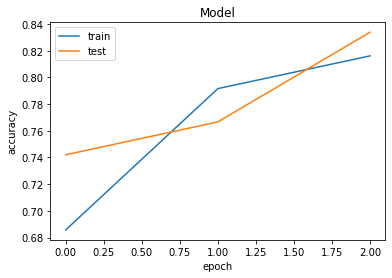

In [16]:
plt.plot(z.history['accuracy'])
plt.plot(z.history['val_accuracy'])
plt.title('Model')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()